In [30]:
%matplotlib inline
import networkx as nx
import csv
import re
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from networkx.algorithms.connectivity import minimum_st_edge_cut
from networkx.algorithms.flow import shortest_augmenting_path
from sklearn.cluster import KMeans


In [8]:
def L1 (x,y):
    dist = 0
    if len(x)==len(y):
        for i in range(len(x)):
            dist += math.fabs(x[i]-y[i])
        return(dist)
    else:
        print('vectors must be equal length for L1')
        return (Null)


In [2]:
i = 0

with open('training.1600000.processed.noemoticon.csv') as f_in:
    for line in f_in:
        print (list(csv.reader(line, skipinitialspace=True)))
        print (line)
        i+=1
        if i>3:
            break

[['0'], ['', ''], ['1467810369'], ['', ''], ['Mon Apr 06 22:19:45 PDT 2009'], ['', ''], ['NO_QUERY'], ['', ''], ['_TheSpecialOne_'], ['', ''], ["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"], []]
"0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

[['0'], ['', ''], ['1467810672'], ['', ''], ['Mon Apr 06 22:19:49 PDT 2009'], ['', ''], ['NO_QUERY'], ['', ''], ['scotthamilton'], ['', ''], ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"], []]
"0","1467810672","Mon Apr 06 22:19:49 PDT 2009","NO_QUERY","scotthamilton","is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"

[['0'], ['', ''], ['1467810917'], ['', ''], ['Mon Apr 06 22:19:53 PDT 2009'], ['', '

In [3]:

G=nx.Graph()
m=0
n=0

with open('training.1600000.processed.noemoticon.csv', encoding='latin-1') as f_in:
    for line in f_in:
        lineX = list(csv.reader(line, skipinitialspace=True))
        G.add_node(lineX[8][0])
        if '@' in lineX[10][0]:
            m+=1
            for t in re.split('[^a-zA-Z\_\@]', lineX[10][0]):
                if t!='' and t[0]=='@' and t!='@':
                    G.add_edge(lineX[8][0],t[1:])
                    n+=1
        if n%100000==0:
            print(n)
print(nx.number_of_nodes(G))

100000
100000
100000
100000
100000
100000
100000
200000
200000
300000
300000
400000
500000
600000
700000
889334


In [20]:
print(nx.number_of_edges(G))

616462


In [5]:
"""0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
1 - the id of the tweet (2087)
2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)
3 - the query. If there is no query, then this value is NO_QUERY.
4 - the user that tweeted
5 - the text of the tweet"""
cols = ['polarity','tweetID','date','Query','UserID','text']
f_in = pd.read_csv('training.1600000.processed.noemoticon.csv',names=cols,encoding='latin-1')#names=m_cols ,


In [6]:

G=nx.Graph()
m=0
n=0

for index, row in f_in.iterrows():
    G.add_node(row[4])
    if '@' in row[5]:
        m+=1
        for t in re.split('[^a-zA-Z\_\@]', row[5]):
            if t!='' and t[0]=='@':
                G.add_edge(row[4],t[1:])
                n+=1

KeyboardInterrupt: 

In [21]:
nx.number_of_edges(G)/nx.number_of_nodes(G)

0.6931726437986179

In [22]:
DegList = list(nx.degree(G).values())
DegDic = {}
for D in DegList:
    if D in DegDic:
        DegDic[D] += 1
    else:
        DegDic[D] = 1

(array([  8.89308000e+05,   1.50000000e+01,   7.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([    0.,   345.,   690.,  1035.,  1380.,  1725.,  2070.,  2415.,
         2760.,  3105.,  3450.]),
 <a list of 10 Patch objects>)

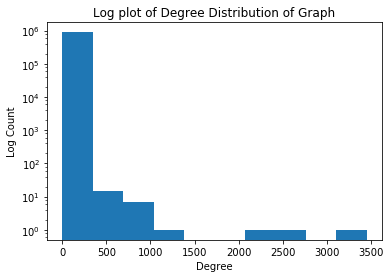

In [23]:
plt.yscale('log')
plt.ylabel('Log Count')
plt.title('Log plot of Degree Distribution of Graph')
plt.xscale('linear')
plt.xlabel('Degree')
plt.hist(DegList)

In [24]:
DegList = list(nx.degree(G).items())
for D in DegList:
    if D[1]>3000:
        print(D)


('mileycyrus', 3450)


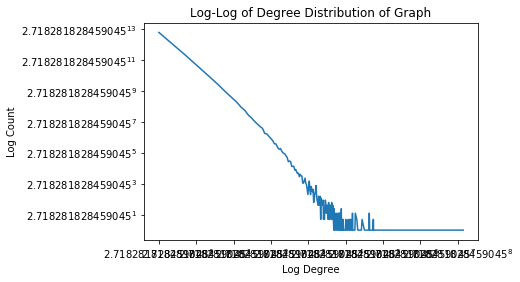

In [25]:
plt.title('Log-Log of Degree Distribution of Graph')
plt.ylabel('Log Count')
plt.xlabel('Log Degree')
DegList = sorted(DegDic.items())
Xlist, Ylist = zip(*DegList)
plt.loglog(Xlist,Ylist, basex=np.e, basey=np.e)
del Xlist
del Ylist

In [27]:
del DegDic
del DegList

In [5]:
LargestCC = max(nx.connected_component_subgraphs(G), key=len) # largest connected component
print(nx.number_of_nodes(LargestCC))

339766


In [6]:
LargestCC.remove_edges_from(LargestCC.selfloop_edges())
scaler = MinMaxScaler((50,800))

In [ ]:
CoreCounts = []
for i in range(2,10):
    core_i = nx.k_core(LargestCC, i)
    CoreCounts.append(nx.number_of_nodes(core_i))
del core_i

In [ ]:
plt.yscale('log')
plt.plot(range(2,10),CoreCounts)

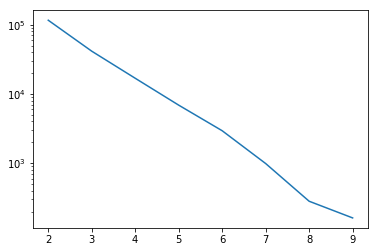

In [37]:
#WOWWWWWWWW worth including

In [9]:
core7 = nx.k_core(LargestCC,7)

In [11]:
Bcent = np.array(list(nx.betweenness_centrality(core7,normalized = True).values()))
scaledBC = scaler.fit_transform(Bcent)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [12]:
Ecent = np.array(list(nx.eigenvector_centrality_numpy(core7).values()))
scaledEC = scaler.fit_transform(Ecent[:,np.newaxis])

In [ ]:
Ccent = np.array(list(nx.closeness_centrality(core7).values()))
scaledCC = scaler.fit_transform(Ccent[:,np.newaxis])

In [17]:
L1_dist = [L1(scaledCC,scaledBC),L1(scaledEC,scaledBC),L1(scaledEC,scaledCC)]
print("""From the three measures we have explored, Eigenvalue centality
Betweenness centality and Closeness centality. We can now evaluate the
L1 distance between the measures""")
D = L1_dist[0]
print("The L1 distance between Closeness centality and Betweenness Centrality is %d implying average distance of %f"%\
      (D, D*1.0/nx.number_of_nodes(core7)))
D = L1_dist[1]
print("The L1 distance between Eigenvalue centality and Betweenness Centrality is %d implying average distance of %f"%\
      (D, D*1.0/nx.number_of_nodes(core7)))
D = L1_dist[2]
print("The L1 distance between Closeness centality and Eigenvalue Centrality is %d implying average distance of %f"%\
      (D, D*1.0/nx.number_of_nodes(core7)))

From the three measures we have explored, Eigenvalue centality
Betweenness centality and Closeness centality. We can now evaluate the
L1 distance between the measures
The L1 distance between Closeness centality and Betweenness Centrality is 386829 implying average distance of 391.527373
The L1 distance between Eigenvalue centality and Betweenness Centrality is 45735 implying average distance of 46.290495
The L1 distance between Closeness centality and Eigenvalue Centrality is 371185 implying average distance of 375.693507


(array([ 929.,   19.,   23.,    5.,    6.,    2.,    2.,    0.,    1.,    1.]),
 array([  50.,  125.,  200.,  275.,  350.,  425.,  500.,  575.,  650.,
         725.,  800.]),
 <a list of 10 Patch objects>)

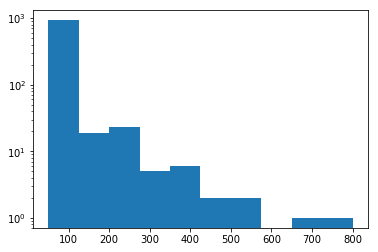

In [18]:
plt.yscale('log')
plt.hist(scaledBC)

(array([ 780.,  146.,   48.,    7.,    0.,    2.,    0.,    2.,    1.,    2.]),
 array([  50.,  125.,  200.,  275.,  350.,  425.,  500.,  575.,  650.,
         725.,  800.]),
 <a list of 10 Patch objects>)

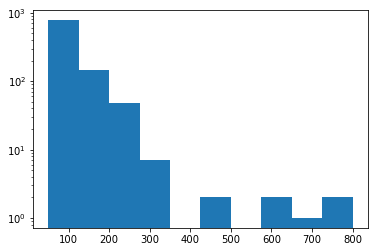

In [19]:
plt.yscale('log')
plt.hist(scaledEC)

(array([  11.,   29.,   31.,   57.,  175.,  252.,  332.,   71.,   21.,    9.]),
 array([  50.,  125.,  200.,  275.,  350.,  425.,  500.,  575.,  650.,
         725.,  800.]),
 <a list of 10 Patch objects>)

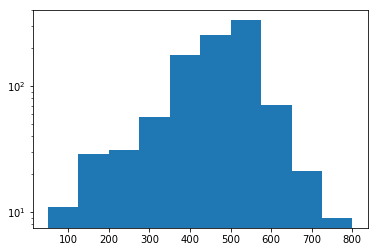

In [21]:
plt.yscale('log')
plt.hist(scaledCC)

In [63]:
f = nx.fiedler_vector(core7)
s = np.zeros(len(f),dtype='int')
s[f>0]=1

/home/ubuntu/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/ubuntu/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold i

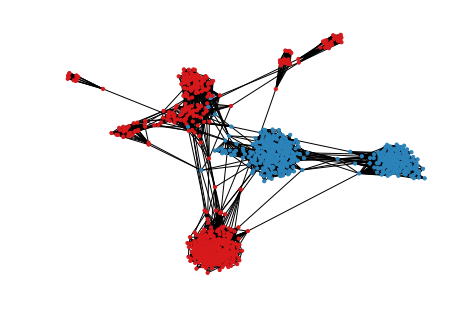

In [64]:
colors = ['#d7191c', '#2b83ba']
node_colors = [colors[s[v]] for v in range(nx.number_of_nodes(core7))]
nx.draw(core7, node_color=node_colors,node_size=10)

In [55]:
L = nx.laplacian_matrix(core7).todense()
w, v = np.linalg.eig(L)
v = np.array(v)
worder = np.argsort(w)
#pos = {i: np.array([f[0], f[1]]) for i, f in enumerate(zip(v[:,worder[1]], v[:,worder[2]]))}

In [56]:
X = v @ np.diag(w)
X = X[:,worder]

In [57]:
error = np.zeros(9)
for k in range(2,11):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit_predict(X[:,1:3])
    error[k-2] = kmeans.inertia_


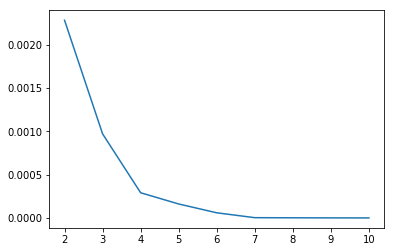

In [58]:
plt.plot(range(2,11),error)

In [68]:
kmeans = KMeans(init='k-means++', n_clusters=6, n_init=10)
kmeans.fit_predict(X[:,1:3])
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_

/home/ubuntu/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/ubuntu/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold i

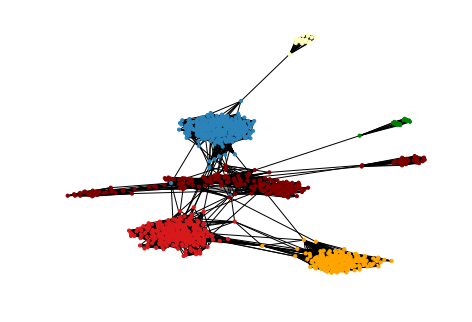

In [70]:
colors = ['#d7191c', '#ffffbf', '#2b83ba', 'green','orange','maroon']
node_colors = [colors[labels[i]] for i in range(nx.number_of_nodes(core7))]
nx.draw(core7, node_color=node_colors,node_size=10)

In [67]:
vectorizer = TfidfVectorizer(stop_words='english', min_df=8, max_df=0.8)
dtm = vectorizer.fit_transform(TextList)

del TextList
terms = vectorizer.get_feature_names()
print("Finished")

NameError: name 'TfidfVectorizer' is not defined